In [11]:
import os
from pathlib import Path

# Print the current working directory
starting_path = os.getcwd()

# Change directory to sleap-roots
if os.path.basename(os.getcwd()) == "sleap-roots":
    pass
else:
    os.chdir("..")
    
current_path = os.getcwd()

print(f"Starting directory: {starting_path}")
print(f"Changed to directory: {current_path}")

Starting directory: c:\Projects\sleap-roots
Changed to directory: c:\Projects\sleap-roots


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

# Import the sleap_roots package
import sleap_roots as sr


# Use the following notation to import individual functions from the sleap_roots package
from sleap_roots.points import get_all_pts_array
from sleap_roots.convhull import get_convhull, get_chull_area, get_chull_perimeter
from sleap_roots.lengths import get_root_lengths, get_curve_index
from sleap_roots.bases import get_bases, get_base_tip_dist
from sleap_roots.tips import get_tips

The `YoungerMonocotPipeline` was constructed for single, monocot plants in cylinders with 72 frame image series.  
The monocot is usually up to 6 days-old, or as long as the primary root is obvious.     
It expects h5 files, primary and crown root predictions per cylinder. 

In [13]:
# Print sleap_roots version
print(sr.__version__)

0.1.3


In [14]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

Current directory: c:\Projects\sleap-roots


In [41]:
folder_path = "tests/data/rice_3do" # Location of h5 files and predictions for young monocots
pipeline_folder_path = "tests/data/rice_3do_pipeline_output" 

# Find all h5 files in the folder
all_h5s = sr.find_all_h5_paths(folder_path)

# Find all slp files in the folder, consists of crown root and primary predictions
all_slps = sr.find_all_slp_paths(folder_path)

print(f"all_h5s: {all_h5s}")
print(f"all_slps: {all_slps}")

all_h5s: ['tests/data/rice_3do/0K9E8BI.h5', 'tests/data/rice_3do/YR39SJX.h5']
all_slps: ['tests/data/rice_3do/0K9E8BI.crown.predictions.slp', 'tests/data/rice_3do/0K9E8BI.primary.predictions.slp', 'tests/data/rice_3do/YR39SJX.crown.predictions.slp', 'tests/data/rice_3do/YR39SJX.primary.predictions.slp']


In [59]:
# Load the cylinder series (one per h5 file)
all_series = sr.load_series_from_slps(all_slps, h5s=True) # The folder containts *.h5 files so we set h5s = True

Example usage for one sample

In [60]:
# Get the first series in the list
series = all_series[0]
print(f"First sample has name {series.series_name}")
print(f"First sample video info: {series.video}")

First sample has name 0K9E8BI
First sample video info: Video(filename="tests/data/rice_3do/0K9E8BI.h5", shape=(72, 1080, 2048, 1), dataset=vol, backend=HDF5Video)


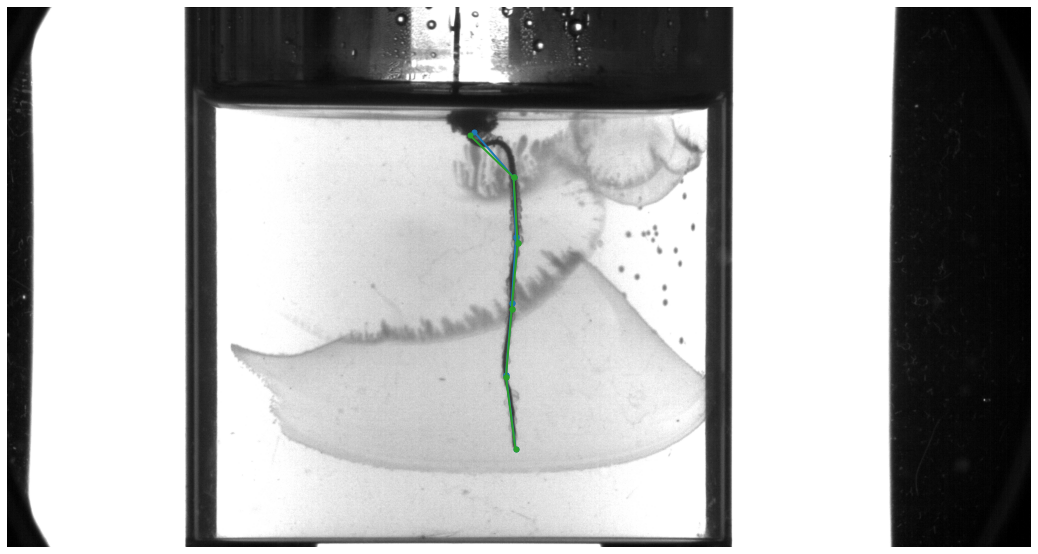

In [71]:
# Plot the first frame of the first series
series.plot(0, scale=0.5)

In [62]:
# Get the primary root points for the first frame
primary_pts = series.get_primary_points(0)
print(f"Shape of primary points: {primary_pts.shape}")

# Get the crown root points for the first frame
crown_pts = series.get_crown_points(0)
print(f"Shape of crown points: {crown_pts.shape}")

Shape of primary points: (1, 6, 2)
Shape of crown points: (1, 6, 2)


In [63]:
# Get primary root lengths for the first frame
primary_lengths = get_root_lengths(primary_pts)
print(f"Primary root length of first frame is {primary_lengths} px")

# Get crown root lengths for the first frame
crown_lengths = get_root_lengths(crown_pts)
print(f"crown root lengths shape is {crown_lengths.shape}")

Primary root length of first frame is 667.0283737228092 px
crown root lengths shape is ()


In [64]:
# Get base point of the primary root
primary_base = get_bases(primary_pts)

# Get tip point of the primary root
primary_tip = get_tips(primary_pts)

# Get the distance between the base and tip of the primary root
base_tip_dist = get_base_tip_dist(primary_base, primary_tip)
print(f"Distance between base and tip of primary root is {base_tip_dist} px")

# Get the curve index (measure of curvature between 0 and 1) of the primary root
curve_index = get_curve_index(primary_lengths, base_tip_dist)
print(f"Curve index of primary root is {curve_index}")

Distance between base and tip of primary root is 640.6712254978028 px
Curve index of primary root is 0.03951428344479904


In [65]:
# Aggregate the primary and crown points in one flattened array
all_pts = get_all_pts_array(primary_pts, crown_pts)
print(f"Shape of all points: {all_pts.shape}")

# Get the convex hull of the primary and crown points
convhull = get_convhull(all_pts)

# Get the area of the convex hull
chull_area = get_chull_area(convhull)
print(f"Area of convex hull is {chull_area} px^2")

# Get the perimeter of the convex hull
chull_perimeter = get_chull_perimeter(convhull)
print(f"Perimeter of convex hull is {chull_perimeter} px")

Shape of all points: (12, 2)
Area of convex hull is 26295.28556367385 px^2
Perimeter of convex hull is 1311.2029656738423 px


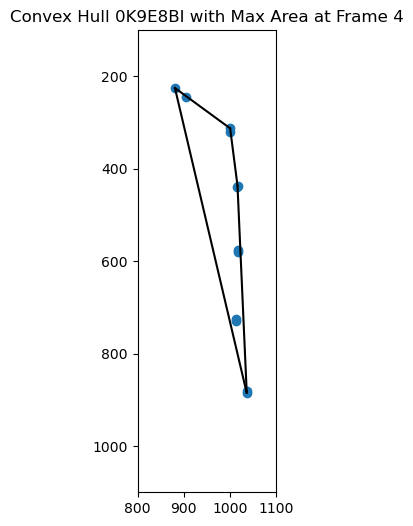

In [66]:
# Find the frame with the largest convex hull area and plot it

# Initialize lists to store the convex hull areas
hull, area = [], []

# Run convex hull features on all frames for primary and crown roots
for i in range(len(series)):
    # Get primary root points
    primary_pts = series.get_primary_points(i)
    # Get crown root points
    crown_pts = series.get_crown_points(i)
    # Aggregate the primary and crown points in one flattened array
    all_pts = get_all_pts_array(primary_pts, crown_pts)

    # Get the convex hull of the primary and crown points
    convhull = get_convhull(all_pts)
    # Get the area of the convex hull
    chull_area = get_chull_area(convhull)

    # Append the convex hull and convex hull area to the lists
    hull.append(convhull)
    area.append(chull_area)

    
# Frame with the max convex hull area
idx_max_area = np.nanargmax(area)

# Plot convex hull of frame with the max width
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(hull[idx_max_area].points[:,0], hull[idx_max_area].points[:,1], 'o')
for simplex in hull[idx_max_area].simplices:
    ax.plot(hull[idx_max_area].points[simplex, 0], hull[idx_max_area].points[simplex, 1], 'k-')

plt.title(f"Convex Hull {series.series_name} with Max Area at Frame {idx_max_area}")    
plt.xlim([800, 1100])
plt.ylim([1100, 100]) # Invert y-axis to match image coordinates
ax.set_aspect('equal')  # Set aspect ratio to 1
plt.show()



Use the `YoungerMonocotPipeline` to calculate all traits

In [67]:
# Initialize the pipeline
pipeline = sr.YoungerMonocotPipeline()

In [68]:
# Compute the traits for one plant
plant_traits_df = pipeline.compute_plant_traits(series, write_csv=True)

In [69]:
# Display the plant traits
plant_traits_df

,plant_name,frame_idx,crown_count,crown_lengths_min,crown_lengths_max,crown_lengths_mean,crown_lengths_median,crown_lengths_std,crown_lengths_p5,crown_lengths_p25,...,chull_line_lengths_std,chull_line_lengths_p5,chull_line_lengths_p25,chull_line_lengths_p75,chull_line_lengths_p95,curve_index,primary_base_tip_dist,ellipse_ratio,scanline_last_ind,scanline_first_ind
0,0K9E8BI,0,1,667.944922,667.944922,667.944922,667.944922,0.0,667.944922,667.944922,...,197.992928,124.171247,157.808979,510.900569,612.002845,0.039514,640.671225,11.423172,40,12
1,0K9E8BI,1,1,675.568403,675.568403,675.568403,675.568403,0.0,675.568403,675.568403,...,199.527821,126.537090,158.936350,515.536905,617.677309,0.038008,637.873340,11.018686,40,12
2,0K9E8BI,2,1,683.144771,683.144771,683.144771,683.144771,0.0,683.144771,683.144771,...,203.805975,125.833348,154.730390,524.043941,623.394493,0.047708,642.089682,10.697450,40,12
3,0K9E8BI,3,1,702.339776,702.339776,702.339776,702.339776,0.0,702.339776,702.339776,...,212.817908,124.667665,154.703719,544.923785,640.393526,0.046684,647.017462,10.942177,40,11
4,0K9E8BI,4,1,722.773905,722.773905,722.773905,722.773905,0.0,722.773905,722.773905,...,210.175719,130.922107,173.801104,541.796626,651.203417,0.051927,649.818719,9.656454,40,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0K9E8BI,67,1,656.460170,656.460170,656.460170,656.460170,0.0,656.460170,656.460170,...,175.719319,121.745944,166.899977,471.647668,593.419060,0.027987,636.020424,13.889125,40,12
68,0K9E8BI,68,1,655.662261,655.662261,655.662261,655.662261,0.0,655.662261,655.662261,...,175.092941,121.237686,166.410245,469.153990,591.558474,0.031188,632.767787,13.901598,40,12
69,0K9E8BI,69,1,660.628014,660.628014,660.628014,660.628014,0.0,660.628014,660.628014,...,195.848738,124.651057,158.618177,503.534431,609.892824,0.031075,637.418432,12.174068,40,12
70,0K9E8BI,70,1,664.420249,664.420249,664.420249,664.420249,0.0,664.420249,664.420249,...,198.218816,123.321806,155.207524,508.085467,611.700813,0.037171,638.673383,12.077704,40,12


In [70]:
# Compute the traits for all plants in the folder and get summary statistics per plant
csv_path = "my_summarized_traits.csv" # Modify this path to save the summarized traits
pipeline.compute_batch_traits(all_series, write_csv=True, csv_path=csv_path)

Processing series: 0K9E8BI
Processing series: YR39SJX
Batch traits saved to my_summarized_traits.csv


,plant_name,crown_count_min,crown_count_max,crown_count_mean,crown_count_median,crown_count_std,crown_count_p5,crown_count_p25,crown_count_p75,crown_count_p95,...,scanline_last_ind_p95,scanline_first_ind_min,scanline_first_ind_max,scanline_first_ind_mean,scanline_first_ind_median,scanline_first_ind_std,scanline_first_ind_p5,scanline_first_ind_p25,scanline_first_ind_p75,scanline_first_ind_p95
0,0K9E8BI,1,2,1.013889,1.0,0.117030,1.0,1.0,1.0,1.0,...,40.0,11,12,11.361111,11.0,0.480323,11.0,11.0,12.0,12.0
1,YR39SJX,1,4,2.013889,2.0,0.697078,1.0,2.0,2.0,3.0,...,43.0,12,13,12.208333,12.0,0.406116,12.0,12.0,12.0,13.0
